![https://cis.ieee.org/images/files/template/cis-logo.png](https://cis.ieee.org/images/files/template/cis-logo.png)

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
%%time
warnings.simplefilter('ignore')
files = ['../input/ieee-fraud-detection/test_identity.csv', 
         '../input/ieee-fraud-detection/test_transaction.csv',
         '../input/ieee-fraud-detection/train_identity.csv',
         '../input/ieee-fraud-detection/train_transaction.csv',
         '../input/ieee-fraud-detection/sample_submission.csv']

def load_data(file):
    return reduce_mem_usage(pd.read_csv(file))

with multiprocessing.Pool() as pool:
    test_identity, test_transaction, train_identity, train_transaction, sample_submission = pool.map(load_data, files)

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to  2.90 Mb (62.5% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
CPU times: user 2.18 s, sys: 3.3 s, total: 5.48 s
Wall time: 4min 29s


# Visualize the Dataset

<pre><b>Credits to Leonardo's Kernel : 
https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt</b></pre>

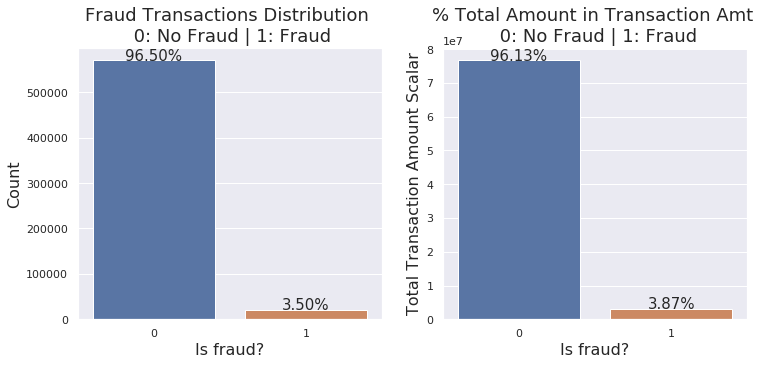

In [4]:
train_transaction['TransactionAmt'] = train_transaction['TransactionAmt'].astype(float)
total = len(train_transaction)
total_amt = train_transaction.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_tr = sns.countplot(x='isFraud', data=train_transaction)
plot_tr.set_title("Fraud Transactions Distribution \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr.set_xlabel("Is fraud?", fontsize=16)
plot_tr.set_ylabel('Count', fontsize=16)
for p in plot_tr.patches:
    height = p.get_height()
    plot_tr.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 
    
percent_amt = (train_transaction.groupby(['isFraud'])['TransactionAmt'].sum())
percent_amt = percent_amt.reset_index()
plt.subplot(122)
plot_tr_2 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=percent_amt)
plot_tr_2.set_title("% Total Amount in Transaction Amt \n 0: No Fraud | 1: Fraud", fontsize=18)
plot_tr_2.set_xlabel("Is fraud?", fontsize=16)
plot_tr_2.set_ylabel('Total Transaction Amount Scalar', fontsize=16)
for p in plot_tr_2.patches:
    height = p.get_height()
    plot_tr_2.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 

<pre><b>Ploting Transaction Amount Values Distribution</b></pre>

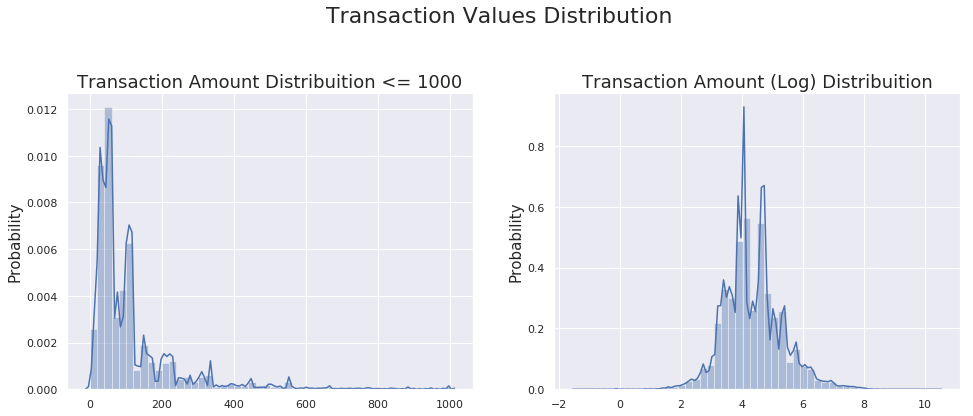

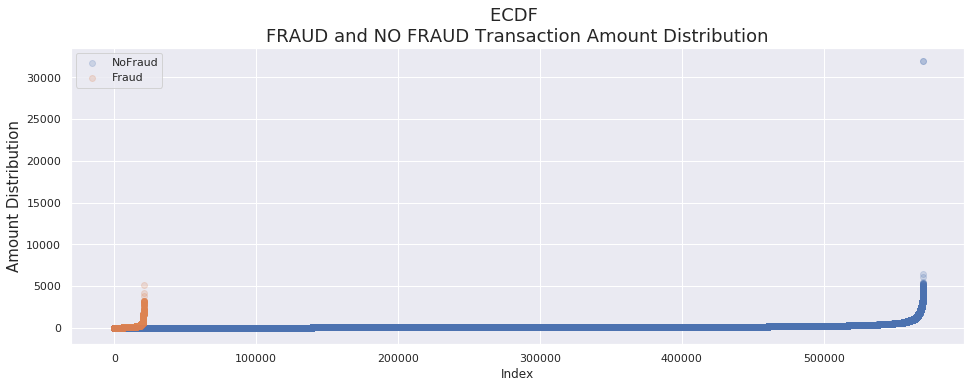

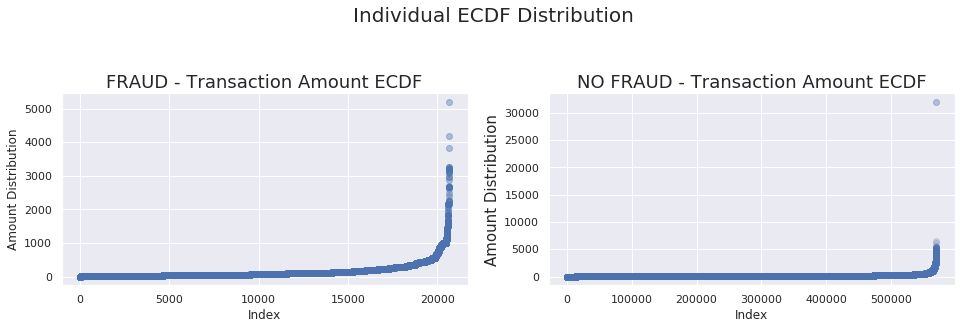

In [5]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
sub_plot_1 = sns.distplot(train_transaction[train_transaction['TransactionAmt'] <= 1000]['TransactionAmt'])
sub_plot_1.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
sub_plot_1.set_xlabel("")
sub_plot_1.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
sub_plot_2 = sns.distplot(np.log(train_transaction['TransactionAmt']))
sub_plot_2.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
sub_plot_2.set_xlabel("")
sub_plot_2.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_3 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
sub_plot_3= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
sub_plot_3 = plt.xlabel("Index")
sub_plot_3 = plt.ylabel("Amount Distribution", fontsize=15)
sub_plot_3 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
sub_plot_4 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 1].shape[0]), 
                 np.sort(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
sub_plot_5 = plt.scatter(range(train_transaction[train_transaction['isFraud'] == 0].shape[0]),
                 np.sort(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
sub_plot_5 = plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
sub_plot_5 = plt.xlabel("Index")
sub_plot_5 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=20)

plt.show()

<pre><b>The Product Feature</b></pre>

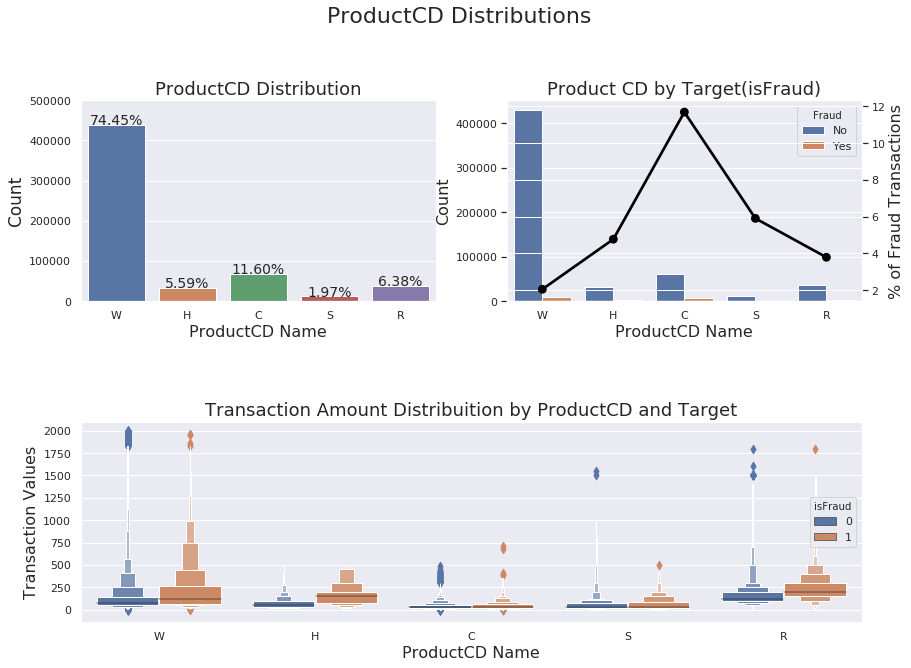

In [6]:
tmp = pd.crosstab(train_transaction['ProductCD'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='ProductCD', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

plot_1.set_title("ProductCD Distribution", fontsize=18)
plot_1.set_xlabel("ProductCD Name", fontsize=16)
plot_1.set_ylabel("Count", fontsize=17)
plot_1.set_ylim(0,500000)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)

plot_2.set_title("Product CD by Target(isFraud)", fontsize=18)
plot_2.set_xlabel("ProductCD Name", fontsize=16)
plot_2.set_ylabel("Count", fontsize=16)

plt.subplot(212)
plot_3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=18)
plot_3.set_xlabel("ProductCD Name", fontsize=16)
plot_3.set_ylabel("Transaction Values", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

<pre><b>Visualizing Card 1, Card 2 and Card 3 Distributions</b></pre>

In [7]:
train_transaction.loc[train_transaction.card3.isin(train_transaction.card3.value_counts()[train_transaction.card3.value_counts() < 200].index), 'card3'] = "Others"
train_transaction.loc[train_transaction.card5.isin(train_transaction.card5.value_counts()[train_transaction.card5.value_counts() < 300].index), 'card5'] = "Others"

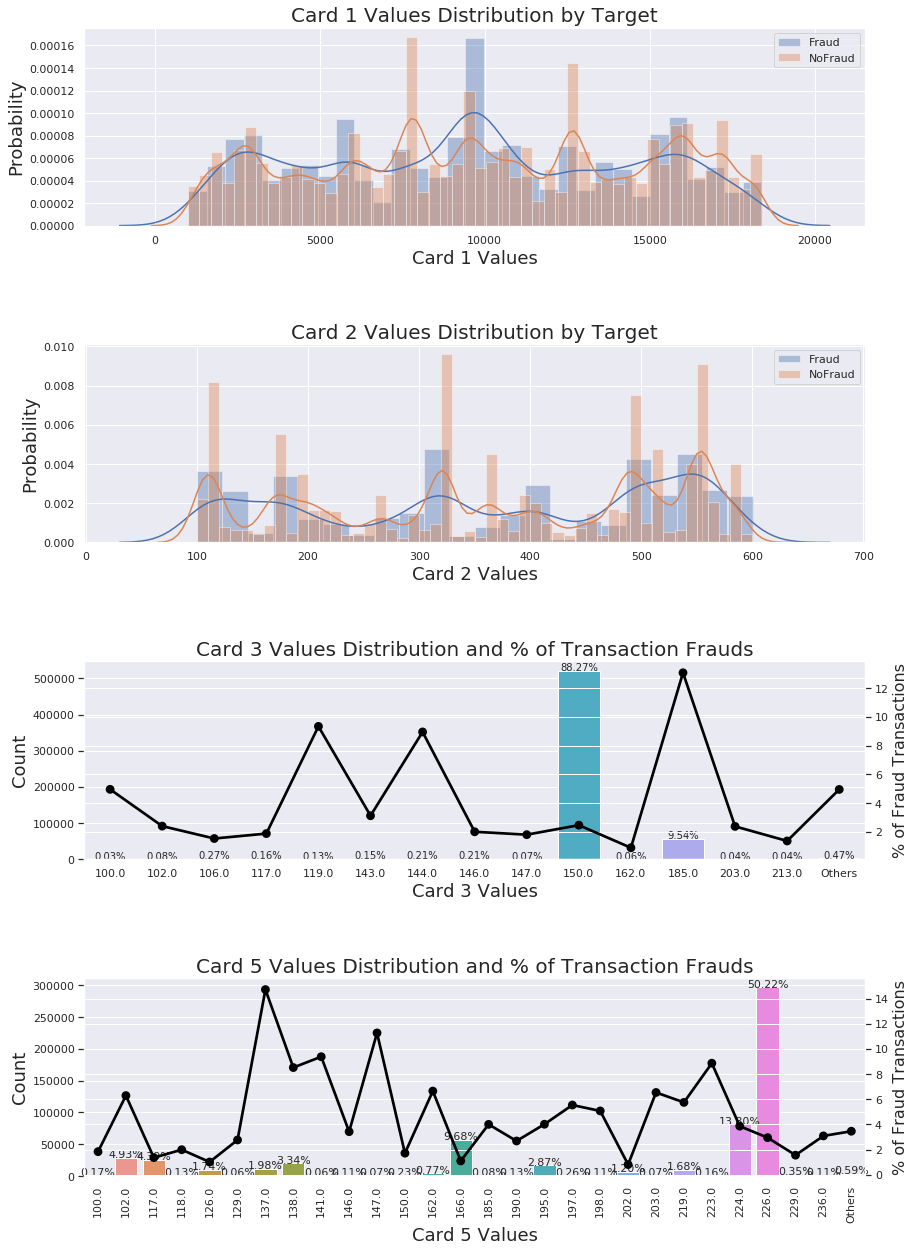

In [8]:
tmp = pd.crosstab(train_transaction['card3'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(train_transaction['card5'], train_transaction['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card1'], label='Fraud')
plot_1 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card1'], label='NoFraud')
plot_1.legend()
plot_1.set_title("Card 1 Values Distribution by Target", fontsize=20)
plot_1.set_xlabel("Card 1 Values", fontsize=18)
plot_1.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['card2'].dropna(), label='Fraud')
plot_2 = sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
plot_2.legend()
plot_2.set_title("Card 2 Values Distribution by Target", fontsize=20)
plot_2.set_xlabel("Card 2 Values", fontsize=18)
plot_2.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
plot_3 = sns.countplot(x='card3', data=train_transaction, order=list(tmp.card3.values))
plot_3_2 = plot_3.twinx()
plot_3_2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
plot_3_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_3.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_3.set_xlabel("Card 3 Values", fontsize=18)
plot_3.set_ylabel("Count", fontsize=18)
for p in plot_3.patches:
    height = p.get_height()
    plot_3.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
plot_4 = sns.countplot(x='card5', data=train_transaction, order=list(tmp2.card5.values))
plot_4_2 = plot_4.twinx()
plot_4_2 = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
plot_4_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_4.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
plot_4.set_xticklabels(plot_4.get_xticklabels(),rotation=90)
plot_4.set_xlabel("Card 5 Values", fontsize=18)
plot_4.set_ylabel("Count", fontsize=18)
for p in plot_4.patches:
    height = p.get_height()
    plot_4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

<pre><b>Card 4 - Categorical Feature</b></pre>

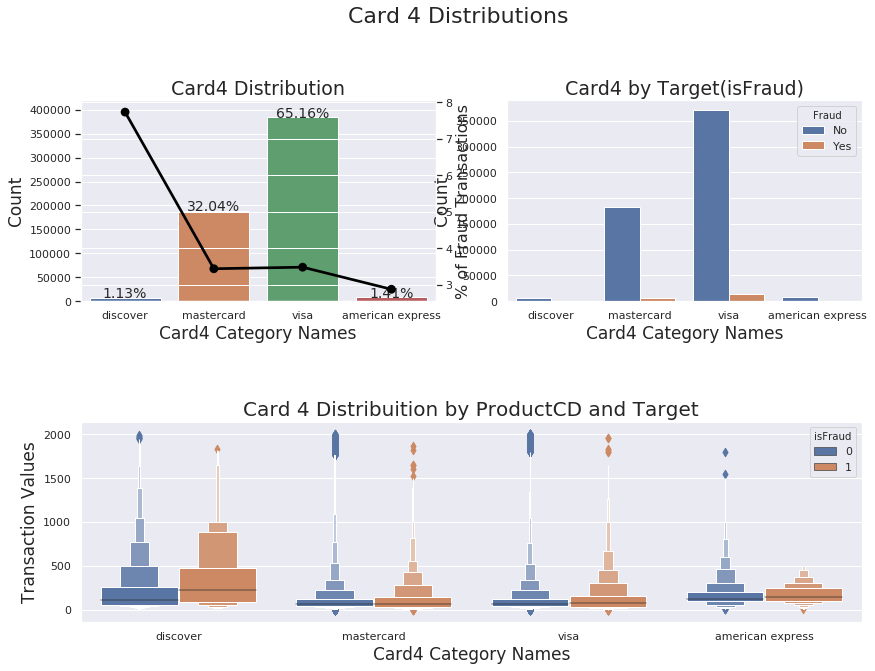

In [9]:
tmp = pd.crosstab(train_transaction['card4'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card4', data=train_transaction)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card4 Distribution", fontsize=19)
plot_1.set_ylim(0,420000)
plot_1.set_xlabel("Card4 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
plot_2 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_1.twinx()
plot_2_2 = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card4 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card4 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card4 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

<pre><b>Card 6 - Categorical</b></pre>

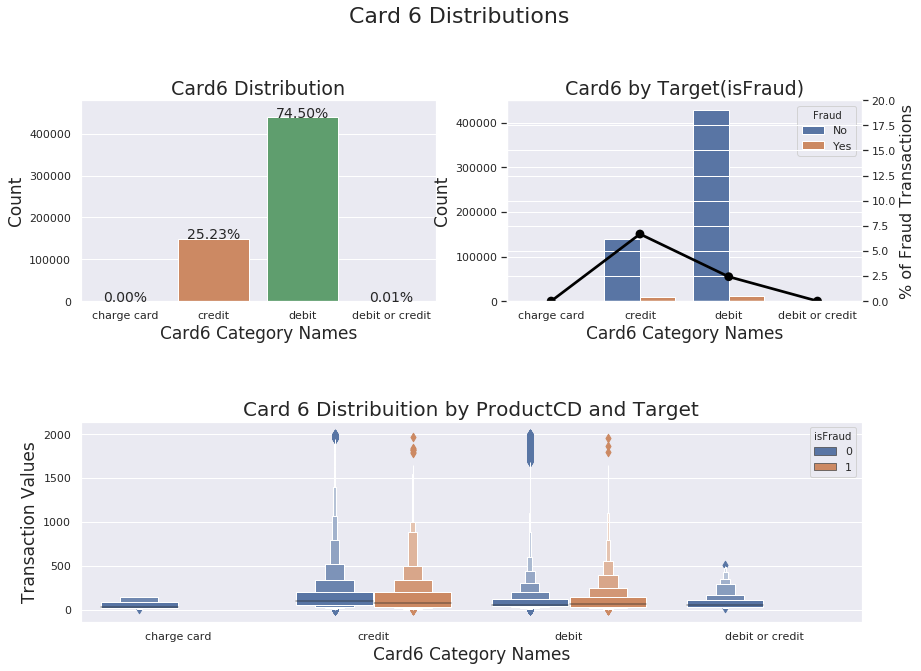

In [10]:
tmp = pd.crosstab(train_transaction['card6'], train_transaction['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
plot_1 = sns.countplot(x='card6', data=train_transaction, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
plot_1.set_title("Card6 Distribution", fontsize=19)
plot_1.set_ylim(0,480000)
plot_1.set_xlabel("Card6 Category Names", fontsize=17)
plot_1.set_ylabel("Count", fontsize=17)
for p in plot_1.patches:
    height = p.get_height()
    plot_1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
plot_2 = sns.countplot(x='card6', hue='isFraud', data=train_transaction, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plot_2_2 = plot_2.twinx()
plot_2_2 = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
plot_2_2.set_ylim(0,20)
plot_2_2.set_ylabel("% of Fraud Transactions", fontsize=16)
plot_2.set_title("Card6 by Target(isFraud)", fontsize=19)
plot_2.set_xlabel("Card6 Category Names", fontsize=17)
plot_2.set_ylabel("Count", fontsize=17)

plt.subplot(212)
plot_3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=train_transaction[train_transaction['TransactionAmt'] <= 2000] )
plot_3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
plot_3.set_xlabel("Card6 Category Names", fontsize=17)
plot_3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

<pre><b>Exploring M1-M9 Features</b></pre>

In [11]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    train_transaction[columns] = train_transaction[columns].fillna("Miss")
    
def ploting_dist_ratio(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{Column} Distributions ', fontsize=22)

    plt.subplot(121)
    plot_1 = sns.countplot(x=Column, data=DataFile, order=list(tmp[Column].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    plot_1.set_title(f"{Column} Distribution\nCound and %Fraud by each category", fontsize=18)
    plot_1.set_ylim(0,400000)
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_1_2.set_ylim(0,20)
    plot_1_2.set_ylabel("% of Fraud Transactions", fontsize=16)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    for p in plot_1_2.patches:
        height = p.get_height()
        plot_1_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (train_transaction.groupby(['isFraud',Column])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    plot_2 = sns.boxplot(x=Column, y='TransactionAmt', hue='isFraud', 
                     data=DataFile[DataFile['TransactionAmt'] <= lim], order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,5)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_title(f"{Column} by Transactions dist", fontsize=18)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

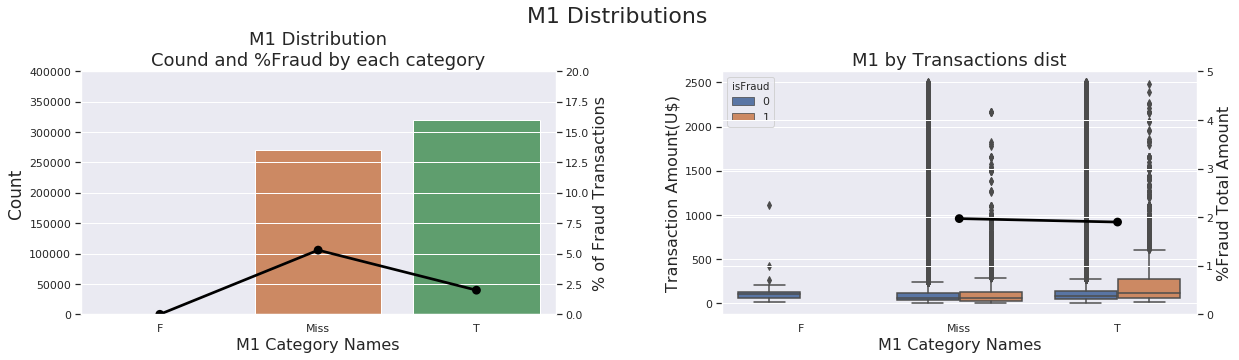

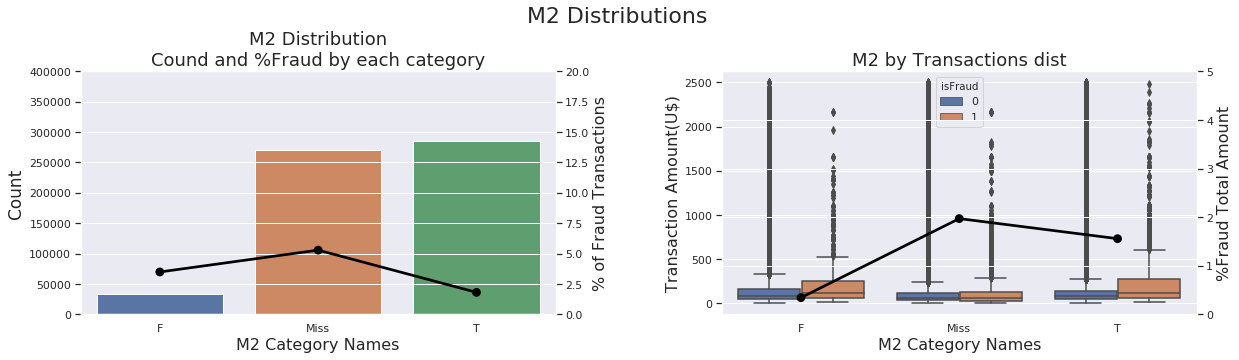

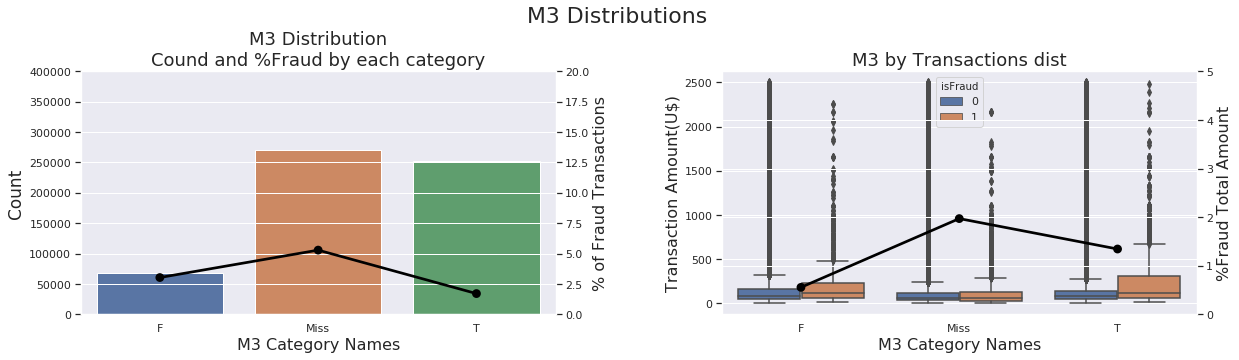

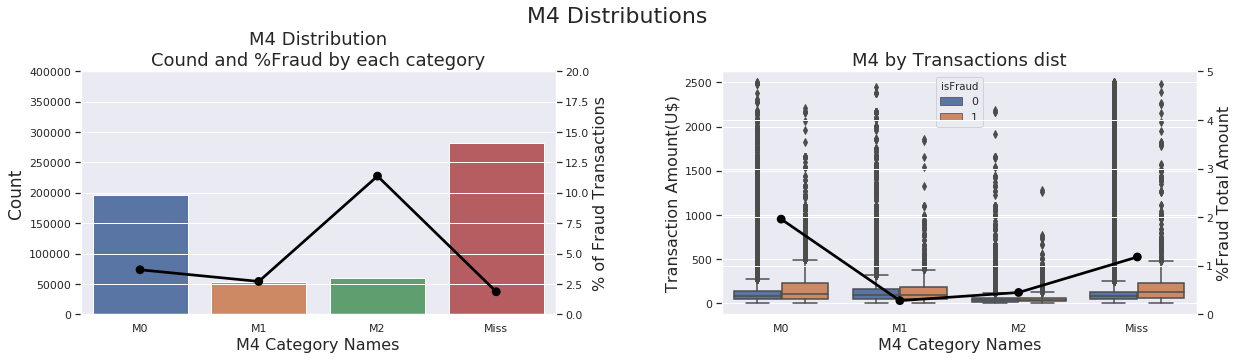

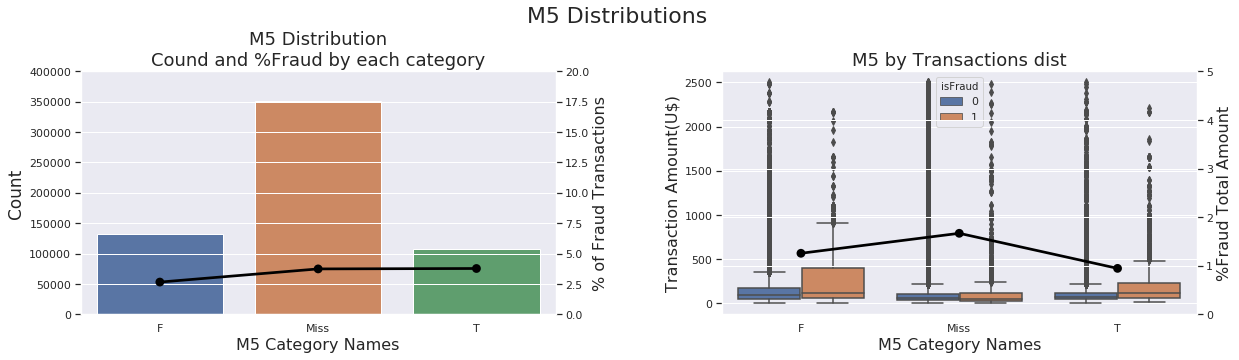

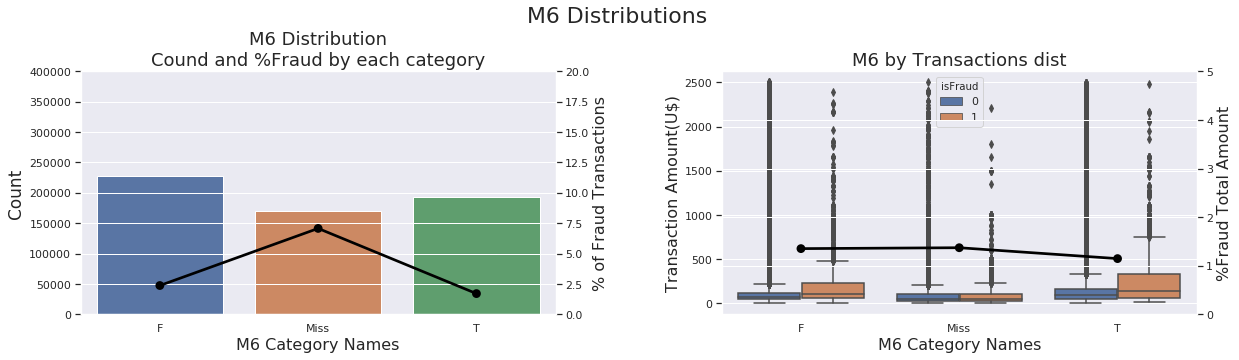

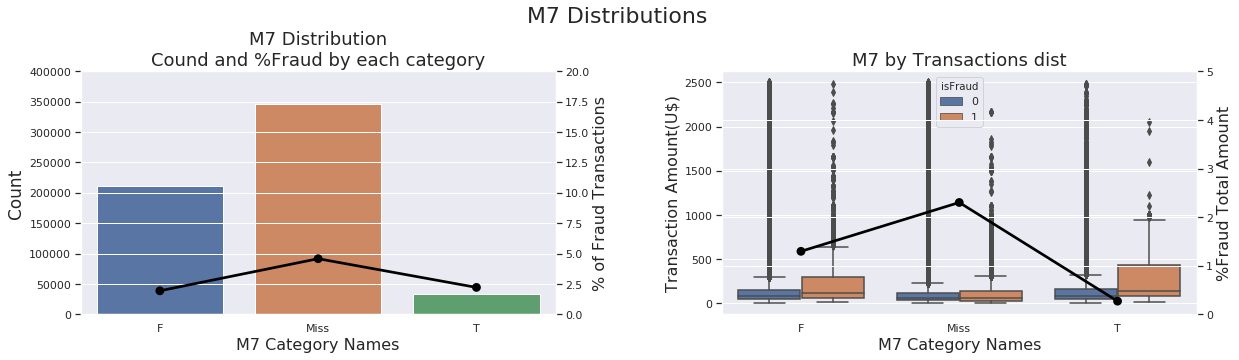

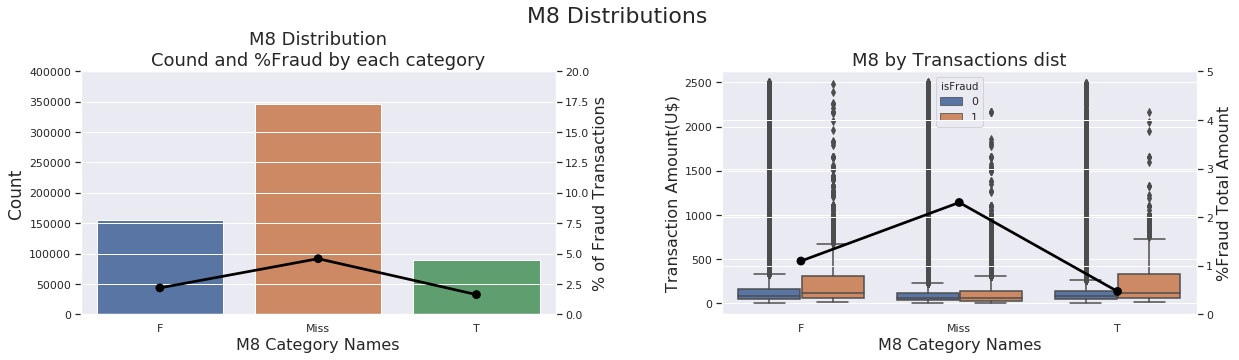

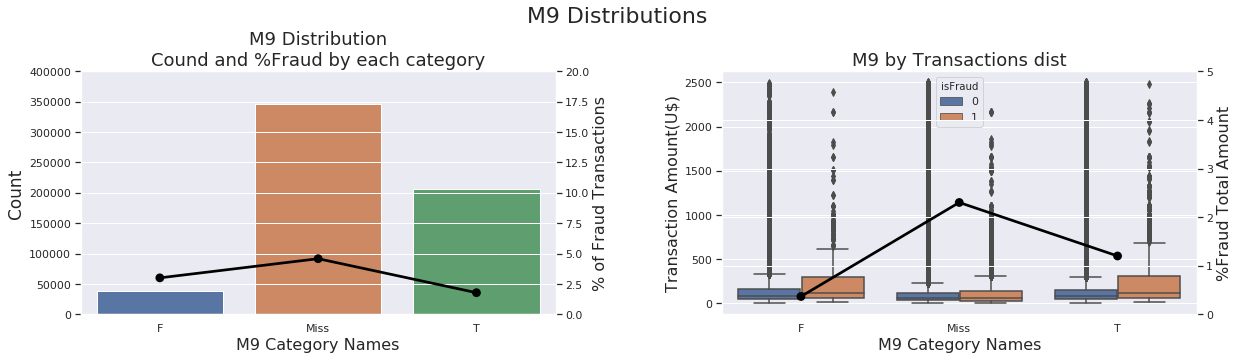

In [12]:
for columns in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(train_transaction, columns, lim=2500)

<pre><b>Addr1 Distributions</b></pre>

In [13]:
train_transaction.loc[train_transaction.addr1.isin(train_transaction.addr1.value_counts()[train_transaction.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
train_transaction.loc[train_transaction.addr2.isin(train_transaction.addr2.value_counts()[train_transaction.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

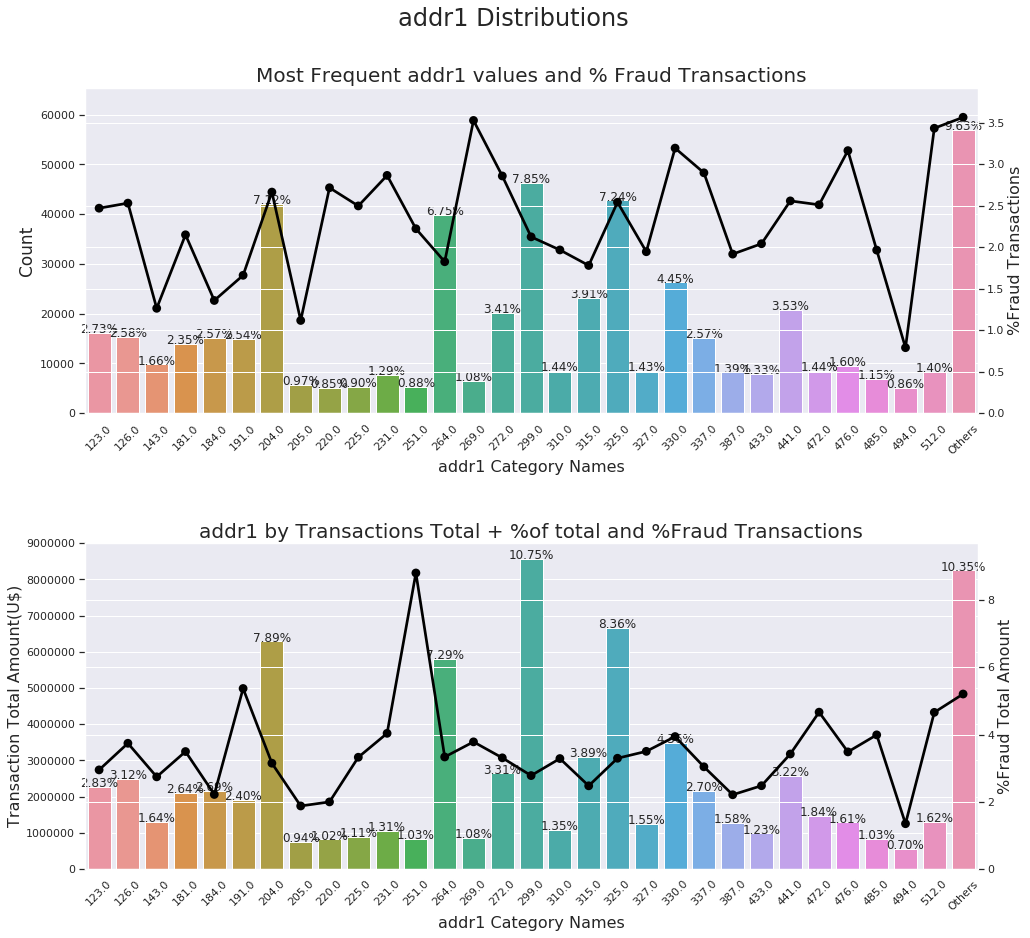

In [14]:
def ploting_cnt_amt(DataFile, Column, lim=2000):
    tmp = pd.crosstab(DataFile[Column], DataFile['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{Column} Distributions ', fontsize=24)
    
    plt.subplot(211)
    plot_1 = sns.countplot(x=Column,data=DataFile,order=list(tmp[Column].values))
    plot_1_2 = plot_1.twinx()
    plot_1_2 = sns.pointplot(x=Column, y='Fraud', data=tmp, order=list(tmp[Column].values),
                       color='black', legend=False)
    plot_1_2.set_ylim(0,tmp['Fraud'].max()*1.1)
    plot_1_2.set_ylabel("%Fraud Transactions", fontsize=16)
    plot_1.set_title(f"Most Frequent {Column} values and % Fraud Transactions", fontsize=20)
    plot_1.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_1.set_ylabel("Count", fontsize=17)
    plot_1.set_xticklabels(plot_1.get_xticklabels(),rotation=45)
    sizes = []
    for p in plot_1.patches:
        height = p.get_height()
        sizes.append(height)
        plot_1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    plot_1.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (DataFile.groupby(['isFraud',Column])['TransactionAmt'].sum() \
                / DataFile.groupby([Column])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = DataFile.groupby([Column])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    plot_2 = sns.barplot(x=Column, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[Column].values))
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=Column, y='Fraud', data=perc_amt, 
                        order=list(tmp[Column].values),
                       color='black', legend=False, )
    plot_2_2.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    plot_2_2.set_ylabel("%Fraud Total Amount", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)
    plot_2.set_title(f"{Column} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    plot_2.set_xlabel(f"{Column} Category Names", fontsize=16)
    plot_2.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    plot_2.set_xticklabels(plot_2.get_xticklabels(),rotation=45)    
    
    for p in plot_2.patches:
        height = p.get_height()
        plot_2.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train_transaction, 'addr1')

<pre><b> ADDR2 Distributions </b></pre>

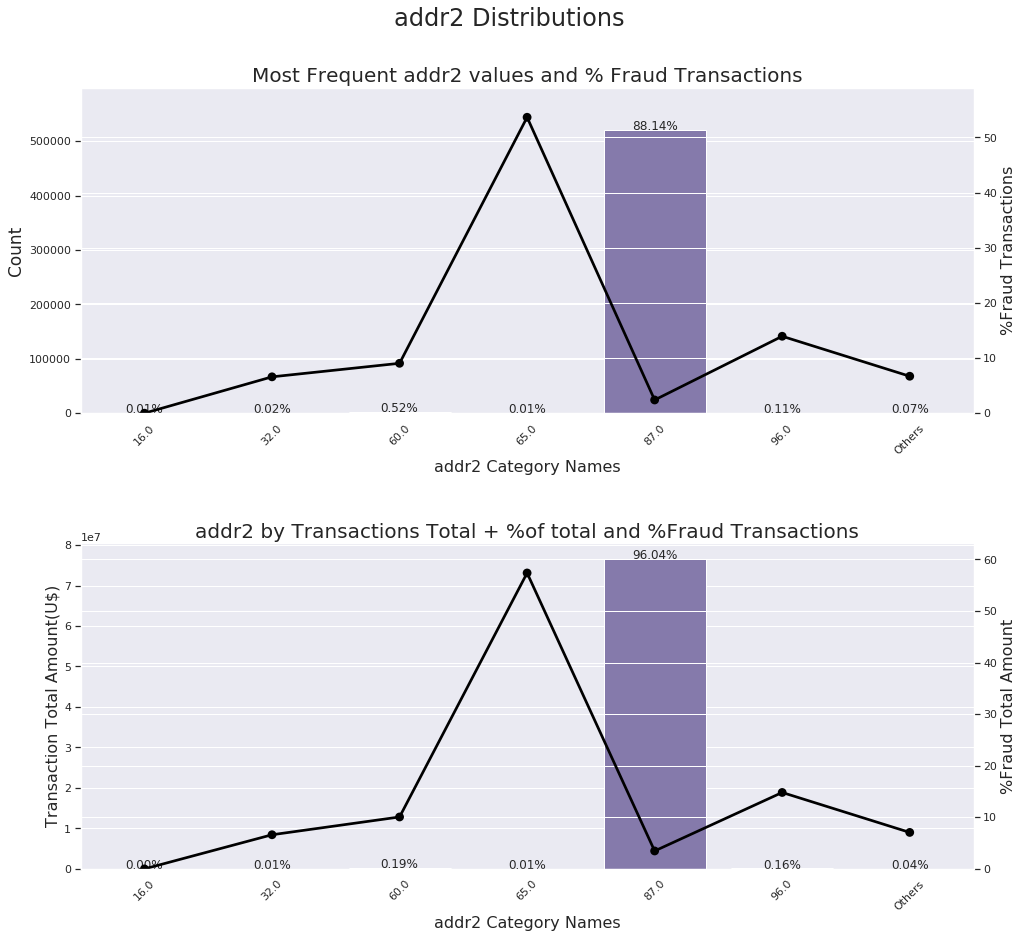

In [15]:
ploting_cnt_amt(train_transaction, 'addr2')

<pre><b>Ploting P-Email Domain</b></pre>

In [16]:
train_transaction.loc[train_transaction['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

train_transaction.loc[train_transaction['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
train_transaction.loc[train_transaction['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
train_transaction.loc[train_transaction.P_emaildomain.isin(train_transaction.P_emaildomain\
                                         .value_counts()[train_transaction.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
train_transaction.P_emaildomain.fillna("NoInf", inplace=True)

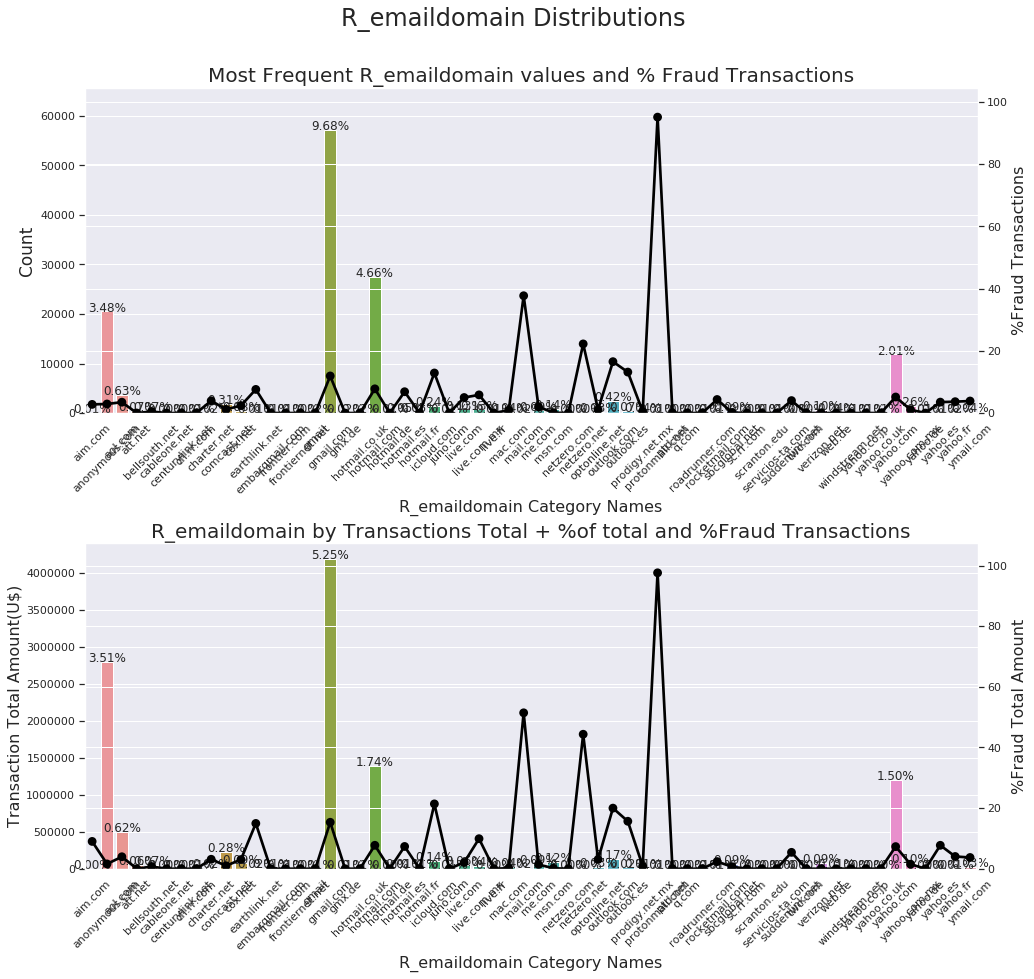

In [17]:
ploting_cnt_amt(train_transaction, 'R_emaildomain')

<pre><b>Exploring C1-C14 features</b></pre>

In [18]:
train_transaction.loc[train_transaction.C1.isin(train_transaction.C1\
                              .value_counts()[train_transaction.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

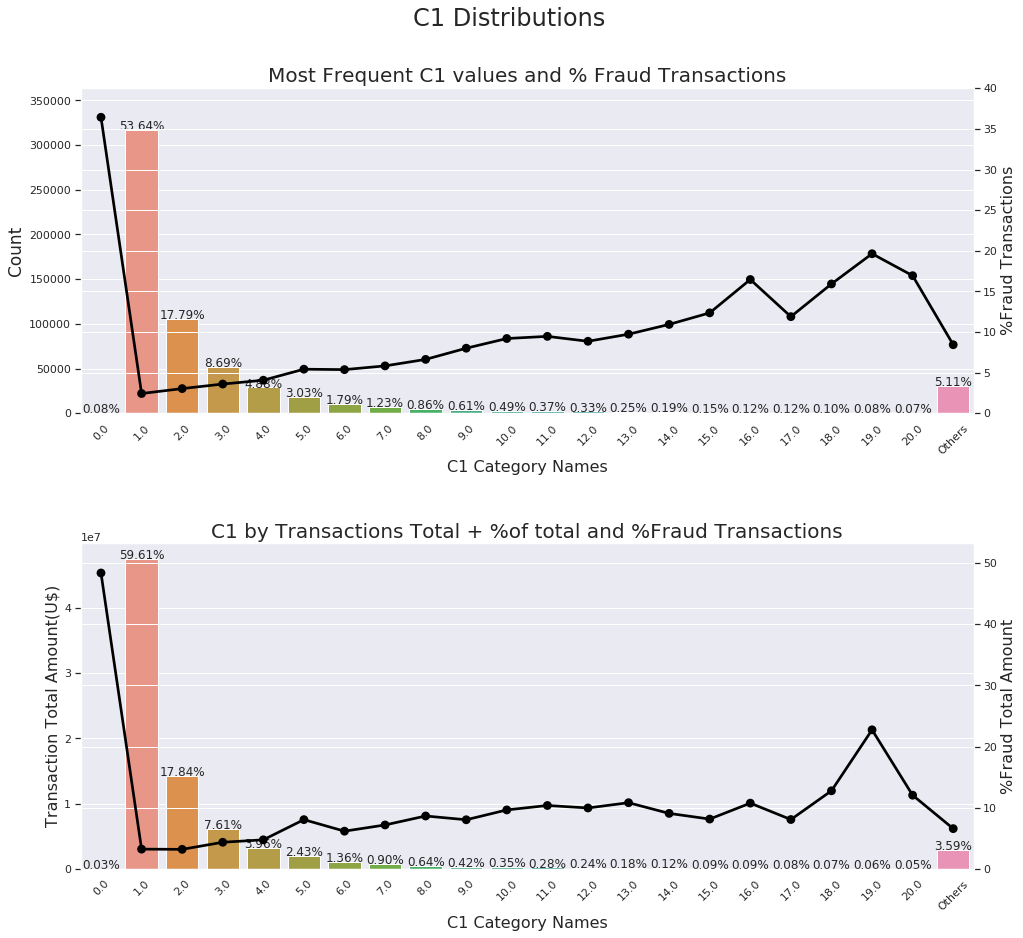

In [19]:
ploting_cnt_amt(train_transaction, 'C1')

In [20]:
train_transaction.loc[train_transaction.C2.isin(train_transaction.C2\
                              .value_counts()[train_transaction.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

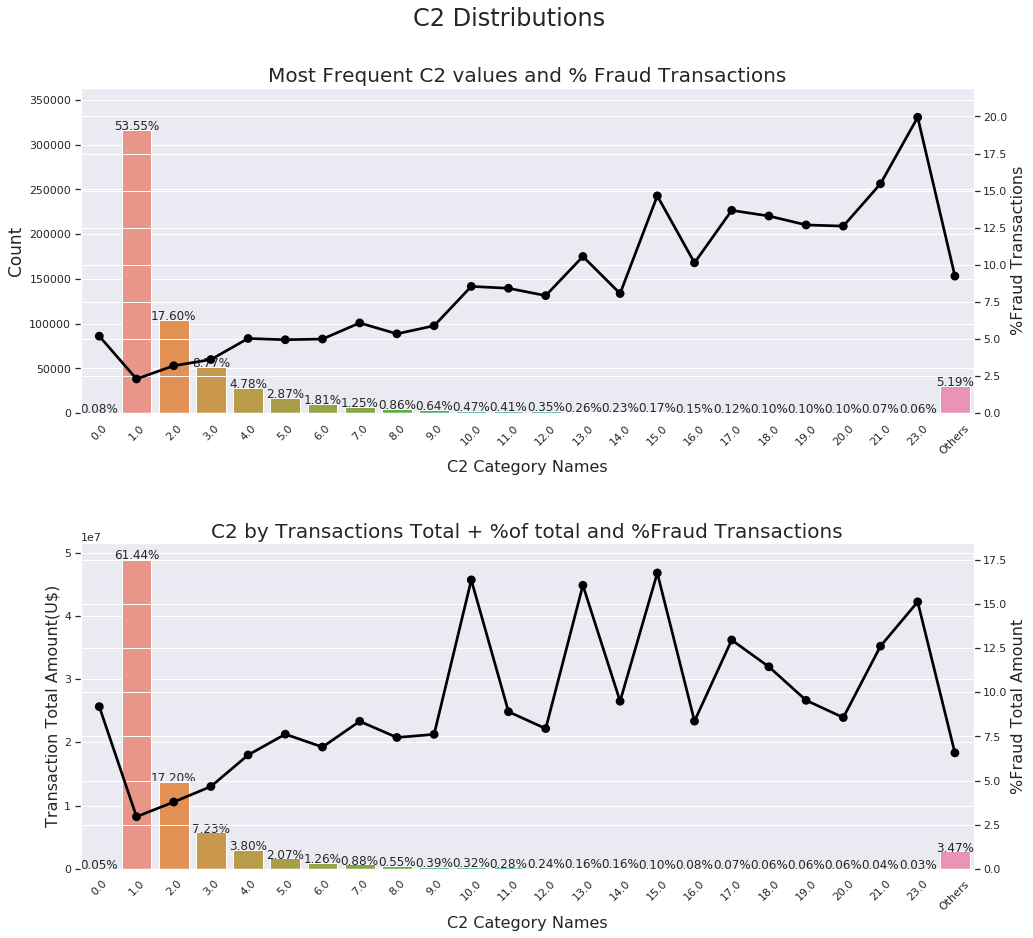

In [21]:
ploting_cnt_amt(train_transaction, 'C2')

TimeDelta Feature to check if frauds have some specific hour that has highest % of frauds</b></pre>

In [22]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train_transaction["Date"] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_Weekdays'] = train_transaction['Date'].dt.dayofweek
train_transaction['_Hours'] = train_transaction['Date'].dt.hour
train_transaction['_Days'] = train_transaction['Date'].dt.day

test_transaction["Date"] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
test_transaction['_Weekdays'] = test_transaction['Date'].dt.dayofweek
test_transaction['_Hours'] = test_transaction['Date'].dt.hour
test_transaction['_Days'] = test_transaction['Date'].dt.day

<pre><b>Top Days with highest Total Transaction Amount</b></pre>

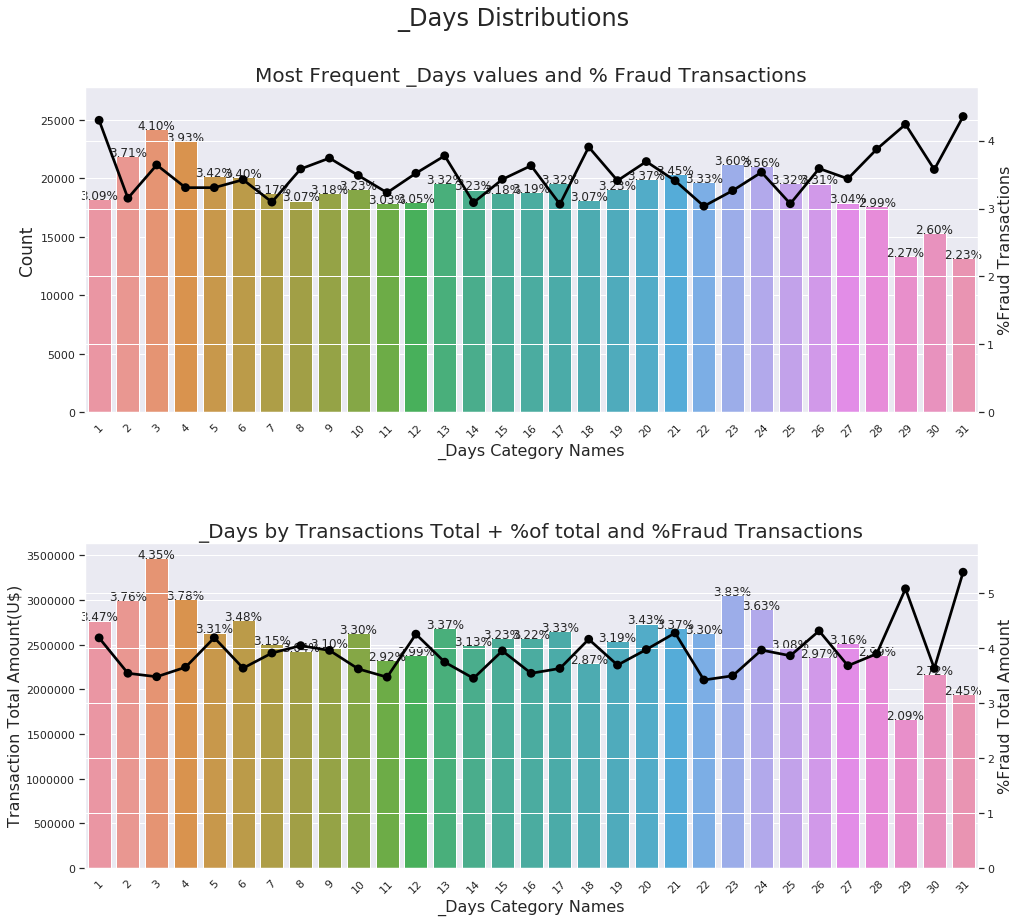

In [23]:
ploting_cnt_amt(train_transaction, '_Days')

<pre><b>Ploting WeekDays Distributions</b></pre>

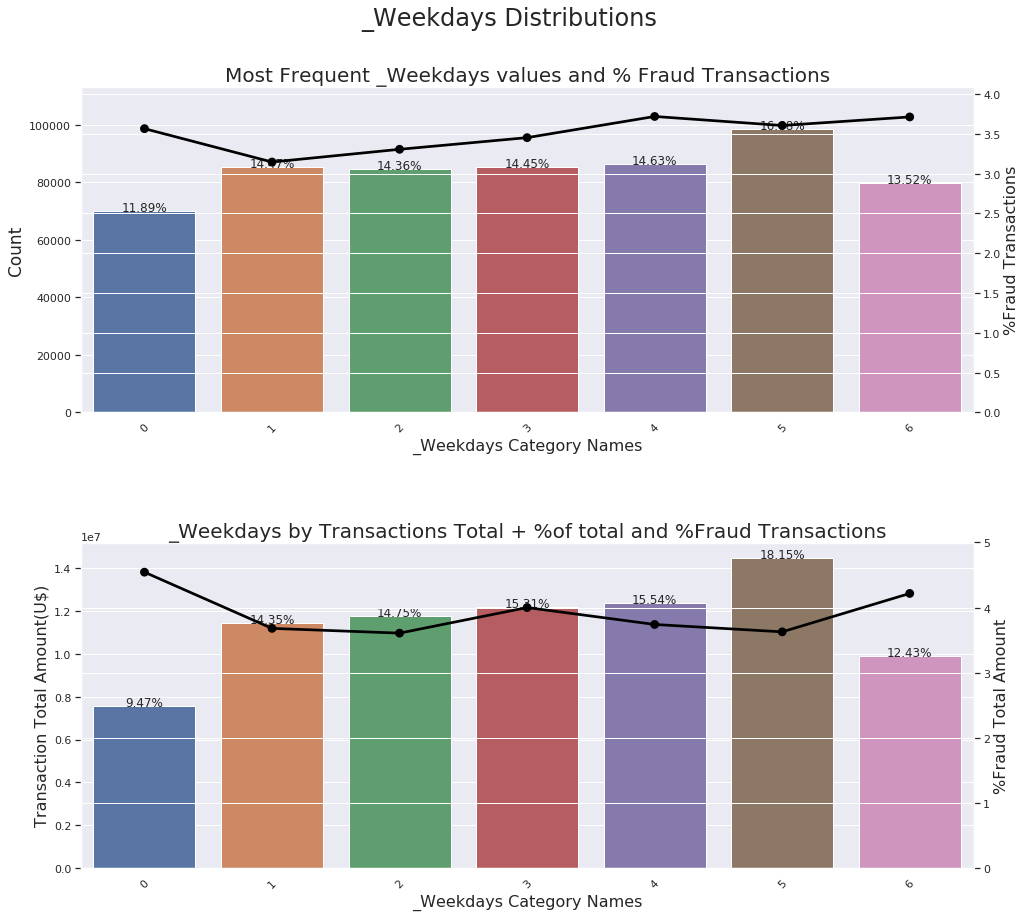

In [24]:
ploting_cnt_amt(train_transaction, '_Weekdays')

<pre><b>Ploting Hours Distributions</b></pre>

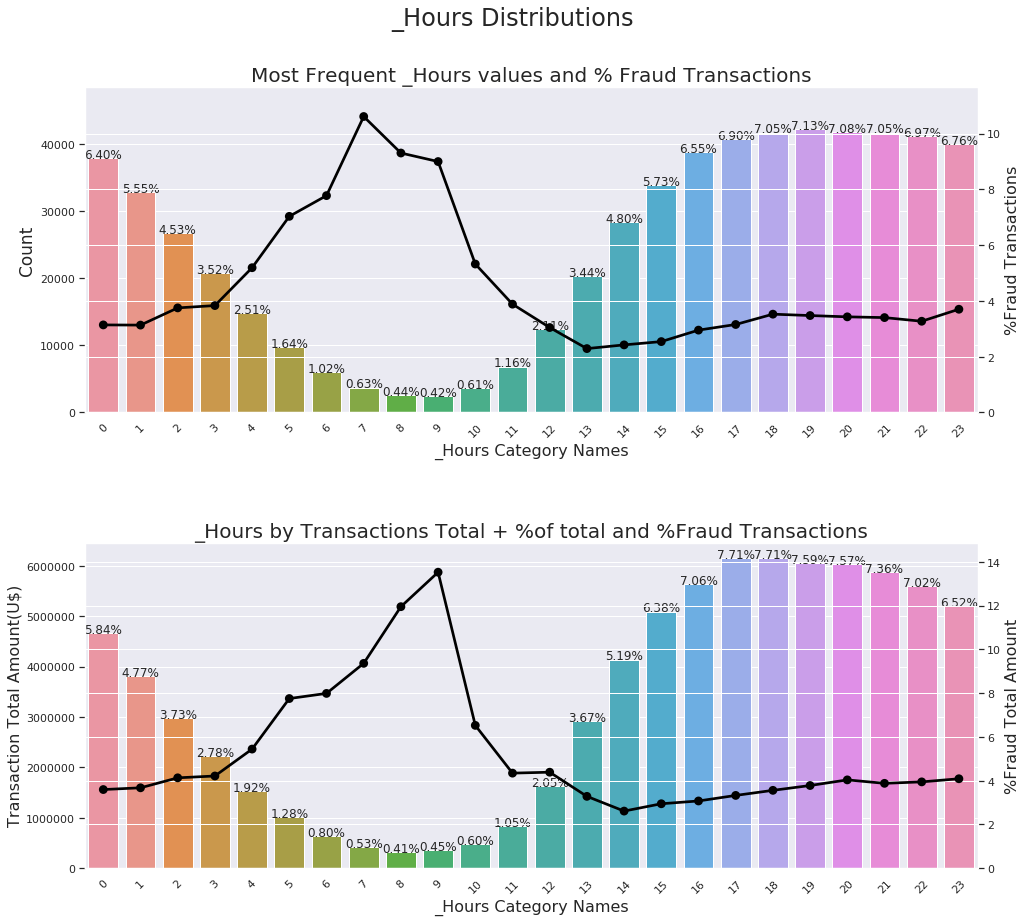

In [25]:
ploting_cnt_amt(train_transaction, '_Hours')

<pre><b>Transactions and Total Amount per day</b></pre>

In [26]:
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

<pre><b>Fraud Transactions by Date</b></pre>

In [27]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']

tmp_amt = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].sum().reset_index()
tmp_trans = train_transaction.groupby([train_transaction.Date.dt.date, 'isFraud'])['TransactionAmt'].count().reset_index()

tmp_trans_fraud = tmp_trans[tmp_trans['isFraud'] == 1]
tmp_amt_fraud = tmp_amt[tmp_amt['isFraud'] == 1]

dates_temp = train_transaction.groupby(train_transaction.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=tmp_trans_fraud['Date'], y=tmp_trans_fraud.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[1]), name= 'Fraud Transactions')

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=tmp_amt_fraud.Date, line = dict(color = color_op[7]), name="Fraud Amount",
                    y=tmp_amt_fraud['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "FRAUD TRANSACTIONS - Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

# Feature Engineering

<pre><b>Credits to Konstantin Yakovlev's Kernel
https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again</b></pre> 

In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [29]:
import lightgbm as lgb

def make_predictions(tr_df, tt_df, features_columns, target, lgb_params, NFOLDS=6):
    
    folds = GroupKFold(n_splits=NFOLDS)

    X,y = tr_df[features_columns], tr_df[target]    
    P,P_y = tt_df[features_columns], tt_df[target]  
    split_groups = tr_df['DT_M']

    tt_df = tt_df[['TransactionID',target]]    
    predictions = np.zeros(len(tt_df))
    oof = np.zeros(len(tr_df))
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
        print('Fold:',fold_)
        tr_x, tr_y = X.iloc[trn_idx,:], y[trn_idx]
        vl_x, vl_y = X.iloc[val_idx,:], y[val_idx]
            
        print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  

        estimator = lgb.train(
            lgb_params,
            tr_data,
            valid_sets = [tr_data, vl_data],
            verbose_eval = 200,
        )   
        
        pp_p = estimator.predict(P)
        predictions += pp_p/NFOLDS
        
        oof_preds = estimator.predict(vl_x)
        oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())

        if LOCAL_TEST:
            feature_imp = pd.DataFrame(sorted(zip(estimator.feature_importance(),X.columns)), columns=['Value','Feature'])
            print(feature_imp)
        
        del tr_x, tr_y, vl_x, vl_y, tr_data, vl_data
        gc.collect()
        
    tt_df['prediction'] = predictions
    print('OOF AUC:', metrics.roc_auc_score(y, oof))
    if LOCAL_TEST:
        print('Holdout AUC:', metrics.roc_auc_score(tt_df[TARGET], tt_df['prediction']))
    
    return tt_df

In [30]:
import os, sys, gc, warnings, random, datetime
SEED = 42
seed_everything(SEED)
LOCAL_TEST = False
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [31]:
print('Load Data')
train_df = pd.read_pickle('../input/ieee-data-minification/train_transaction.pkl')

if LOCAL_TEST:
   
    train_df['DT_M'] = train_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    train_df['DT_M'] = (train_df['DT_M'].dt.year-2017)*12 + train_df['DT_M'].dt.month 
    test_df = train_df[train_df['DT_M']==train_df['DT_M'].max()].reset_index(drop=True)
    train_df = train_df[train_df['DT_M']<(train_df['DT_M'].max()-1)].reset_index(drop=True)
    
    train_identity = pd.read_pickle('../input/ieee-data-minification/train_identity.pkl')
    test_identity  = train_identity[train_identity['TransactionID'].isin(
                                    test_df['TransactionID'])].reset_index(drop=True)
    train_identity = train_identity[train_identity['TransactionID'].isin(
                                    train_df['TransactionID'])].reset_index(drop=True)
    del train_df['DT_M'], test_df['DT_M']
    
else:
    test_df = pd.read_pickle('../input/ieee-data-minification/test_transaction.pkl')
    train_identity = pd.read_pickle('../input/ieee-data-minification/train_identity.pkl')
    test_identity = pd.read_pickle('../input/ieee-data-minification/test_identity.pkl')
    
base_columns = list(train_df) + list(train_identity)
print('Shape control:', train_df.shape, test_df.shape)

Load Data
Shape control: (590540, 394) (506691, 394)


In [32]:
for df in [train_df, test_df]:

    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    df['D9'] = np.where(df['D9'].isna(),0,1)

In [33]:
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)

In [34]:
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train_df, test_df]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [35]:
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card5'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card5'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)

i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)
           
train_df['TransactionAmt'] = np.log1p(train_df['TransactionAmt'])
test_df['TransactionAmt'] = np.log1p(test_df['TransactionAmt'])  

In [36]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train_df, test_df]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

In [37]:
for df in [train_identity, test_identity]:

    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [38]:
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

In [39]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train_df[[col,period]], test_df[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train_df[new_column] = (train_df[col].astype(str) + '_' + train_df[period].astype(str)).map(fq_encode)
        test_df[new_column]  = (test_df[col].astype(str) + '_' + test_df[period].astype(str)).map(fq_encode)
        
        train_df[new_column] /= train_df[period+'_total']
        test_df[new_column]  /= test_df[period+'_total']

In [40]:
for col in ['ProductCD','M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col] = train_df[col].map(temp_dict)
    test_df[col]  = test_df[col].map(temp_dict)

In [41]:
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

P_emaildomain
R_emaildomain
uid
uid2
uid3
P_emaildomain_prefix
R_emaildomain_prefix
id_30
id_31
DeviceType
DeviceInfo
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


In [42]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [43]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_df)).difference(base_columns+rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

features_discard = [] 

# Final features list
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

['M_sum', 'D7_fq_enc', 'D6_fq_enc', 'D4_fq_enc', 'D5_fq_enc', 'uid_DT_D', 'id_31_device', 'D3_fq_enc', 'id_30_version', 'M_na', 'C12_fq_enc']


In [44]:
lgb_params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.01,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'n_estimators':2**9,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'early_stopping_rounds':100,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 

In [45]:
if LOCAL_TEST:
    lgb_params['learning_rate'] = 0.01
    lgb_params['n_estimators'] = 20000
    lgb_params['early_stopping_rounds'] = 100
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params)
    print(metrics.roc_auc_score(test_predictions[TARGET], test_predictions['prediction']))
else:
    lgb_params['learning_rate'] = 0.007
    lgb_params['n_estimators'] = 1800
    lgb_params['early_stopping_rounds'] = 100    
    test_predictions = make_predictions(train_df, test_df, features_columns, TARGET, lgb_params, NFOLDS=6)

Fold: 0
453219 137321
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.952905	valid_1's auc: 0.888639
[400]	training's auc: 0.979365	valid_1's auc: 0.903252
[600]	training's auc: 0.990449	valid_1's auc: 0.910186
[800]	training's auc: 0.995278	valid_1's auc: 0.914488
[1000]	training's auc: 0.99757	valid_1's auc: 0.917014
[1200]	training's auc: 0.998719	valid_1's auc: 0.918654
[1400]	training's auc: 0.999281	valid_1's auc: 0.919748
[1600]	training's auc: 0.999618	valid_1's auc: 0.920493
[1800]	training's auc: 0.999797	valid_1's auc: 0.920926
Did not meet early stopping. Best iteration is:
[1800]	training's auc: 0.999797	valid_1's auc: 0.920926
Fold: 1
488908 101632
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.953564	valid_1's auc: 0.912002
[400]	training's auc: 0.978885	valid_1's auc: 0.929386
[600]	training's auc: 0.990916	valid_1's auc: 0.9375
[800]	training's auc: 0.995677	valid_1's auc: 0.940406
[1000]	tr

In [46]:
if not LOCAL_TEST:
    test_predictions['isFraud'] = test_predictions['prediction']
    test_predictions[['TransactionID','isFraud']].to_csv('submission.csv', index=False)